In [1]:
from google.colab import drive
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.functional as F
import matplotlib.pyplot as plt

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
train_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/data', train=True, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

test_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/data', train=False, download=True, transform=transform)


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
class ConvolutionalNeuralNetwork(nn.Module):
  def __init__(self):
    super(ConvolutionalNeuralNetwork, self).__init__()

    self.model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Flatten(),

        nn.Linear(16*5*5, 128),
        nn.ReLU(),

        nn.Linear(128, 64),
        nn.ReLU(),

        nn.Linear(64, 10)
    )

  def forward(self, X):
    return self.model(X)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ConvolutionalNeuralNetwork()
model = model.to(device)

In [7]:
def train_model(model, train_dataloader, val_dataloader, loss_function, epochs, learning_rate):
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_epoch_losses = []
  train_epoch_accuracies = []

  val_epoch_losses = []
  val_epoch_accuracies = []

  for epoch in range(epochs):
    model.train()

    train_current_epoch_loss = 0.0
    train_current_epoch_correct_predictions = 0
    train_current_epoch_total_predictions = 0

    for batch_idx, (X_batch, y_batch) in enumerate(train_dataloader):
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      optimizer.zero_grad()
      outputs = model(X_batch)
      loss = loss_function(outputs, y_batch)
      loss.backward()
      optimizer.step()

      train_current_epoch_loss += loss.item()
      train_current_epoch_correct_predictions += (outputs.argmax(dim=1) == y_batch).sum().item()
      train_current_epoch_total_predictions += y_batch.size(0)

    train_epoch_losses.append(train_current_epoch_loss / len(train_dataloader))
    train_epoch_accuracies.append(train_current_epoch_correct_predictions / train_current_epoch_total_predictions)

    print(f'Training, Epoch {epoch + 1}/{epochs}, Loss: {train_epoch_losses[-1]}, Accuracy: {train_epoch_accuracies[-1]}')

    model.eval()

    val_current_epoch_loss = 0.0
    val_current_epoch_correct_predictions = 0
    val_current_epoch_total_predictions = 0

    with torch.no_grad():
      for batch_idx, (X_batch, y_batch) in enumerate(val_dataloader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        loss = loss_function(outputs, y_batch)

        val_current_epoch_loss += loss.item()
        val_current_epoch_correct_predictions += (outputs.argmax(dim=1) == y_batch).sum().item()
        val_current_epoch_total_predictions += y_batch.size(0)

    val_epoch_losses.append(val_current_epoch_loss / len(val_dataloader))
    val_epoch_accuracies.append(val_current_epoch_correct_predictions / val_current_epoch_total_predictions)

    print(f'Validation, Epoch {epoch + 1}/{epochs}, Loss: {val_epoch_losses[-1]}, Accuracy: {val_epoch_accuracies[-1]}')

  return train_epoch_losses, train_epoch_accuracies, val_epoch_losses, val_epoch_accuracies

In [8]:
def plot_train_results(train_epoch_losses, train_epoch_accuracies, val_epoch_losses, val_epoch_accuracies):
  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1)
  plt.plot(train_epoch_losses, label='Training Loss', color='blue')
  plt.plot(val_epoch_losses, label='Validation Loss', color='red')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Losses')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(train_epoch_accuracies, label='Training Accuracy', color='blue')
  plt.plot(val_epoch_accuracies, label='Validation Accuracy', color='red')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracies')
  plt.legend()

  plt.tight_layout()
  plt.show()

Training, Epoch 1/10, Loss: 1.843764072227478, Accuracy: 0.319225
Validation, Epoch 1/10, Loss: 1.6292043263745155, Accuracy: 0.3993
Training, Epoch 2/10, Loss: 1.5130526329040528, Accuracy: 0.445675
Validation, Epoch 2/10, Loss: 1.495354883230416, Accuracy: 0.4567
Training, Epoch 3/10, Loss: 1.4002396007537843, Accuracy: 0.489925
Validation, Epoch 3/10, Loss: 1.4027743088971278, Accuracy: 0.4985
Training, Epoch 4/10, Loss: 1.328948513698578, Accuracy: 0.517875
Validation, Epoch 4/10, Loss: 1.3224009768978047, Accuracy: 0.5278
Training, Epoch 5/10, Loss: 1.2720559021949769, Accuracy: 0.543375
Validation, Epoch 5/10, Loss: 1.2988859718772257, Accuracy: 0.5354
Training, Epoch 6/10, Loss: 1.2145015132904053, Accuracy: 0.5665
Validation, Epoch 6/10, Loss: 1.2663752516363835, Accuracy: 0.5539
Training, Epoch 7/10, Loss: 1.1744624930381775, Accuracy: 0.582075
Validation, Epoch 7/10, Loss: 1.2456179367508857, Accuracy: 0.5551
Training, Epoch 8/10, Loss: 1.135288723373413, Accuracy: 0.5954
Val

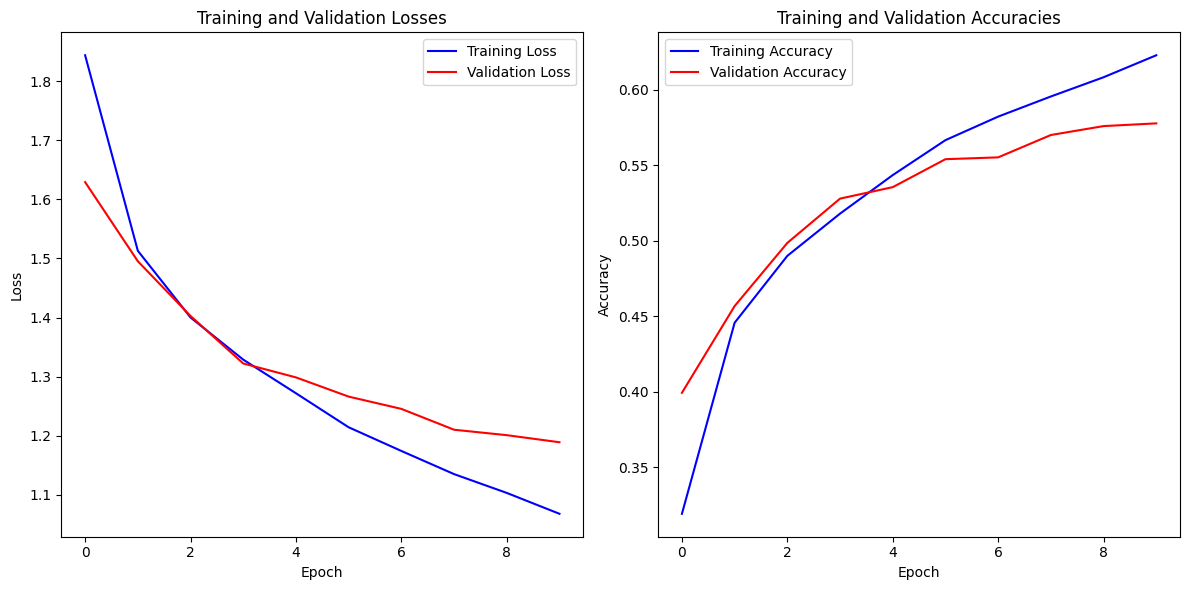

In [9]:
train_epoch_losses, train_epoch_accuracies, val_epoch_losses, val_epoch_accuracies = train_model(model, train_dataloader, val_dataloader, nn.CrossEntropyLoss(), 10, 0.001)
plot_train_results(train_epoch_losses, train_epoch_accuracies, val_epoch_losses, val_epoch_accuracies)

In [10]:
class myLinear(nn.Module):
  def __init__(self, in_features, out_features, device=None):
    super().__init__()
    self.weight = nn.parameter.Parameter(torch.randn(out_features, in_features, device=device))
    self.bias = nn.parameter.Parameter(torch.randn(out_features, device=device))

  def forward(self, X):
    return self.weight @ X + self.bias

In [21]:
linear = nn.Linear(in_features=8, out_features=16, device=device)
my_linear = myLinear(in_features=8, out_features=16, device=device)

random_input = torch.randn(8)
random_input = random_input.to(device)

print('Mean Absolute Difference before copy:', torch.mean(torch.abs(linear(random_input) - my_linear(random_input))).item())

my_linear.load_state_dict(linear.state_dict())

print('Mean Absolute Difference after copy:', torch.mean(torch.abs(linear(random_input) - my_linear(random_input))).item())

Mean Absolute Difference before copy: 1.9577713012695312
Mean Absolute Difference after copy: 0.0
